#Uncertainty-weighted loss for B-CNNs

## 1. Imports and Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

!git clone https://github.com/maborghe/UWL_BNN
!mkdir UWL_BNN/dataset

model_path = '/content/drive/My Drive/Bioinformatics/'
os.chdir(model_path + 'dataset')
!cp X_train.npy X_test.npy X_train_flip.npy Y_train.npy Y_test.npy real_classes_train.npy real_classes_test.npy /content/UWL_BNN/dataset/

os.chdir('/content/UWL_BNN/src')

import data_setup, utils, model, network, loss

Cloning into 'UWL_BNN'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 158 (delta 89), reused 106 (delta 44), pack-reused 0
Receiving objects: 100% (158/158), 392.12 KiB | 11.88 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [3]:
x_train, y_train, x_train_real, y_train_real = data_setup.get_train_data()

x_val_real, y_val_real, x_val_fake, y_val_fake,\
           x_test_real, y_test_real, x_test_fake, y_test_fake = data_setup.get_dev_test_data()

Train samples: 12336
Train samples: 12336
x_train shape: (24672, 32, 32, 3)
Training samples:  24672
Real training samples:  12000
Test samples: 7308
Real test samples: 3000
Validation samples:  3654
Test samples:  3654
Real validation samples:  1542
Real test samples:  1458


## 2. Preparatory models

Il lavoro potrebbe consistere in quattro parti:
- Train traditional CNN with only *real* classes, it should test real classes well (i.e. the network is fine)
- Train traditional CNN with all classes, testing real classes should be worse
- Train MC (second model) with all classes, testing real classes should be worse, testing all classes it should recognize fake classes (high variance or similar)
- Train UQ (our model) with all classes, testing real classes should be better (network *should* be more robust), testing all classes could recognize better fake classes or not (interesting to see)

### CNN (real samples only)

In [ ]:
first_model_real = model.get_vanilla_model()
utils.train_model(first_model_real, model_path + 'cnn_real.h5', x_train_real, y_train_real, x_val_real, y_val_real, epochs=30)
acc, _ = utils.evaluate_baseline(first_model_real, x_test_real, y_test_real, False)
print('Test accuracy:', acc)

Epoch 1/30
363/375 [============================>.] - ETA: 0s - loss: 0.3363 - accuracy: 0.8978
Epoch 00001: val_accuracy improved from -inf to 0.91755, saving model to /content/drive/My Drive/Bioinformatics/cnn_real.h5
375/375 [==============================] - 1s 4ms/step - loss: 0.3317 - accuracy: 0.8987 - val_loss: 0.2297 - val_accuracy: 0.9176
Epoch 2/30
371/375 [============================>.] - ETA: 0s - loss: 0.1446 - accuracy: 0.9477
Epoch 00002: val_accuracy improved from 0.91755 to 0.95479, saving model to /content/drive/My Drive/Bioinformatics/cnn_real.h5
375/375 [==============================] - 1s 3ms/step - loss: 0.1444 - accuracy: 0.9478 - val_loss: 0.1608 - val_accuracy: 0.9548
Epoch 3/30
367/375 [============================>.] - ETA: 0s - loss: 0.1055 - accuracy: 0.9610
Epoch 00003: val_accuracy improved from 0.95479 to 0.96144, saving model to /content/drive/My Drive/Bioinformatics/cnn_real.h5
375/375 [==============================] - 1s 3ms/step - loss: 0.1042 - 

### CNN (mixed)

In [ ]:
first_model = model.get_vanilla_model()
utils.train_model(first_model, model_path + 'cnn.h5', x_train, y_train, x_val_real, y_val_real, epochs=30)
acc, _ = utils.evaluate_baseline(first_model, x_test_real, y_test_real, False)
print('Test accuracy:', acc)

Epoch 1/30
764/771 [============================>.] - ETA: 0s - loss: 1.0670 - accuracy: 0.6277
Epoch 00001: val_accuracy improved from -inf to 0.45279, saving model to /content/drive/My Drive/Bioinformatics/cnn.h5
771/771 [==============================] - 3s 3ms/step - loss: 1.0663 - accuracy: 0.6277 - val_loss: 2.2150 - val_accuracy: 0.4528
Epoch 2/30
759/771 [============================>.] - ETA: 0s - loss: 0.7651 - accuracy: 0.6934
Epoch 00002: val_accuracy improved from 0.45279 to 0.54122, saving model to /content/drive/My Drive/Bioinformatics/cnn.h5
771/771 [==============================] - 2s 3ms/step - loss: 0.7653 - accuracy: 0.6932 - val_loss: 1.6842 - val_accuracy: 0.5412
Epoch 3/30
757/771 [============================>.] - ETA: 0s - loss: 0.6630 - accuracy: 0.7247
Epoch 00003: val_accuracy improved from 0.54122 to 0.68152, saving model to /content/drive/My Drive/Bioinformatics/cnn.h5
771/771 [==============================] - 2s 3ms/step - loss: 0.6625 - accuracy: 0.725

### B-CNN

In [ ]:
second_model = model.get_bcnn_model()
utils.train_model(second_model, model_path + 'bnn.h5', x_train, y_train, x_val_real, y_val_real, epochs=30)
second_model.load_weights(model_path + 'bnn.h5')
acc_real, uc_real = utils.evaluate_baseline(second_model, x_test_real, y_test_real, True)
print('Accuracy real', acc_real)  # should be high
print('Uncertainty real', uc_real)  # should be low
_, uc_fake = utils.evaluate_baseline(second_model, x_test_fake, y_test_fake, True)
print('Uncertainty spurious', uc_fake)  # should be high

Epoch 1/30
763/771 [============================>.] - ETA: 0s - loss: 1.0455 - accuracy: 0.6230
Epoch 00001: val_accuracy improved from -inf to 0.65226, saving model to /content/drive/My Drive/Bioinformatics/bnn.h5
771/771 [==============================] - 3s 4ms/step - loss: 1.0423 - accuracy: 0.6233 - val_loss: 1.3915 - val_accuracy: 0.6523
Epoch 2/30
766/771 [============================>.] - ETA: 0s - loss: 0.7981 - accuracy: 0.6799
Epoch 00002: val_accuracy did not improve from 0.65226
771/771 [==============================] - 2s 3ms/step - loss: 0.7962 - accuracy: 0.6809 - val_loss: 1.3507 - val_accuracy: 0.6483
Epoch 3/30
753/771 [============================>.] - ETA: 0s - loss: 0.6903 - accuracy: 0.7082
Epoch 00003: val_accuracy improved from 0.65226 to 0.69215, saving model to /content/drive/My Drive/Bioinformatics/bnn.h5
771/771 [==============================] - 2s 3ms/step - loss: 0.6891 - accuracy: 0.7085 - val_loss: 1.0662 - val_accuracy: 0.6922
Epoch 4/30
753/771 [===

## 3. Custom model

In [ ]:
import importlib, model
importlib.reload(model)

third_model = model.get_custom_model(loss.my_loss_fct)
history = utils.train_model(third_model, model_path + 'uwl_bnn.h5', x_train, y_train, x_val_real, y_val_real, epochs=30)
third_model.load_weights(model_path + 'uwl_bnn.h5')
_, acc_real, uc_real = utils.evaluate_custom(third_model, x_test_real, y_test_real)
print('Accuracy real', acc_real)  # should be high
print('Uncertainty real', uc_real)  # should be low
_, __, uc_fake = utils.evaluate_custom(third_model, x_test_fake, y_test_fake)
print('Uncertainty spurious', uc_fake)  # should be high

Epoch 1/30
771/771 [==============================] - ETA: 0s - loss: 0.4596 - custom_acc: 0.7293 - custom_uc: 0.1611
Epoch 00001: val_custom_acc improved from -inf to 0.72407, saving model to /content/drive/My Drive/Bioinformatics/uwl_bnn.h5
771/771 [==============================] - 84s 109ms/step - loss: 0.4596 - custom_acc: 0.7293 - custom_uc: 0.1611 - val_loss: 0.4335 - val_custom_acc: 0.7241 - val_custom_uc: 0.1245
Epoch 2/30
771/771 [==============================] - ETA: 0s - loss: 0.3801 - custom_acc: 0.7778 - custom_uc: 0.1384
Epoch 00002: val_custom_acc improved from 0.72407 to 0.74003, saving model to /content/drive/My Drive/Bioinformatics/uwl_bnn.h5
771/771 [==============================] - 78s 102ms/step - loss: 0.3801 - custom_acc: 0.7778 - custom_uc: 0.1384 - val_loss: 0.4991 - val_custom_acc: 0.7400 - val_custom_uc: 0.1148
Epoch 3/30
771/771 [==============================] - ETA: 0s - loss: 0.3437 - custom_acc: 0.8009 - custom_uc: 0.1290
Epoch 00003: val_custom_acc i

**Plot training history**

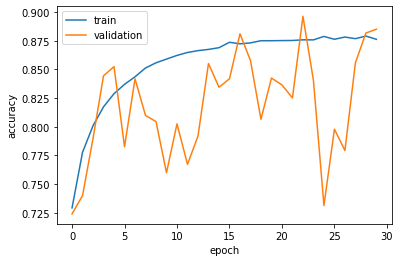

In [ ]:
plt.plot(history.history['custom_acc'])
plt.plot(history.history['val_custom_acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Plot accuracy and uncertainties vs repetitions**

In [ ]:
repetitions = [2, 5, 10, 15, 20, 30, 50]

models = []

for rep in repetitions:  
    utils.t = rep
    tmp_model = model.get_custom_model(loss.my_loss_fct)
    model_name = model_path + 'uwl_bnn_' + str(rep) + '.h5'
    utils.train_model(tmp_model, model_name, x_train, y_train, x_test_real, y_val_real, epochs=30)    
    tmp_model.load_weights(model_name)
    models.append(tmp_model)

models.append(third_model)


Epoch 1/30
770/771 [============================>.] - ETA: 0s - loss: 0.7106 - custom_acc: 0.6388 - custom_uc: 0.1653
Epoch 00001: val_custom_acc improved from -inf to 0.70856, saving model to /content/drive/My Drive/Bioinformatics/uwl_bnn_2.h5
771/771 [==============================] - 8s 10ms/step - loss: 0.7102 - custom_acc: 0.6390 - custom_uc: 0.1653 - val_loss: 0.8474 - val_custom_acc: 0.7086 - val_custom_uc: 0.1179
Epoch 2/30
767/771 [============================>.] - ETA: 0s - loss: 0.5621 - custom_acc: 0.7045 - custom_uc: 0.1495
Epoch 00002: val_custom_acc did not improve from 0.70856
771/771 [==============================] - 7s 9ms/step - loss: 0.5610 - custom_acc: 0.7052 - custom_uc: 0.1495 - val_loss: 1.0736 - val_custom_acc: 0.6515 - val_custom_uc: 0.1176
Epoch 3/30
770/771 [============================>.] - ETA: 0s - loss: 0.5099 - custom_acc: 0.7263 - custom_uc: 0.1423
Epoch 00003: val_custom_acc did not improve from 0.70856
771/771 [==============================] - 7s 

68/68 [==============================] - 3s 50ms/step - loss: 0.8101 - custom_acc: 0.4835 - custom_uc: 0.1955


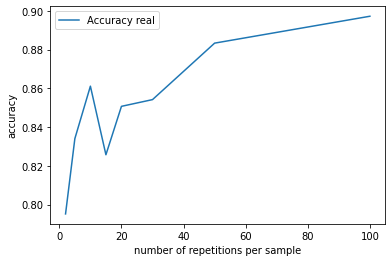

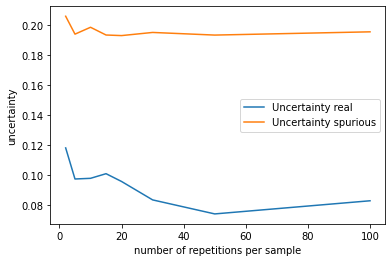

In [9]:
real_accs = []
real_ucs = []
fake_accs =[]
fake_ucs  = []
for model in models:
  _, acc_real, uc_real = utils.evaluate_custom(model, x_test_real, y_test_real)
  _, acc_fake, uc_fake = utils.evaluate_custom(model, x_test_fake, y_test_fake)
  real_accs.append(acc_real)
  real_ucs.append(uc_real)
  fake_accs.append(acc_fake)
  fake_ucs.append(uc_fake)

# plot accuracy
plt.plot(repetitions + [100], real_accs, label = "Accuracy real")
plt.xlabel('number of repetitions per sample')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# plot uncertainties
plt.plot(repetitions + [100], real_ucs, label = "Uncertainty real")
plt.plot(repetitions + [100], fake_ucs, label = "Uncertainty spurious")
plt.xlabel('number of repetitions per sample')
plt.ylabel('uncertainty')
plt.legend()
plt.show()

**Plot histograms**

In [ ]:
def print_histo(model, x_test, y_test):
  y_pred = list()

  for t in range(utils.t):
        y_pred.append(model.predict(x_test))

  y_pred = np.array(y_pred)
  y_pred_mean, y_pred_uc = utils.compute_pred_distribution(y_pred)
  indices = np.argmax(y_pred_mean, axis=1)

  predicted_class_uc = np.asarray([uc[ind] for ind, uc in
                                            zip(indices, y_pred_uc)])


  fig, axes = plt.subplots()
  plt.xlabel('Uncertainty')
  axes.hist(predicted_class_uc, color='b', log=True, bins=25, edgecolor='black', linewidth=1.2);
  predictions = model.predict(x_test)
  

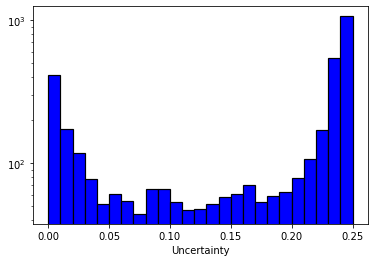

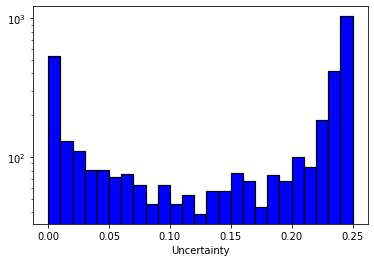

In [ ]:
print_histo(second_model, np.concatenate((x_test_real, x_test_fake)), np.concatenate((y_test_real, y_test_fake)))
print_histo(third_model, np.concatenate((x_test_real, x_test_fake)), np.concatenate((y_test_real, y_test_fake)))

**Plot ROCs**

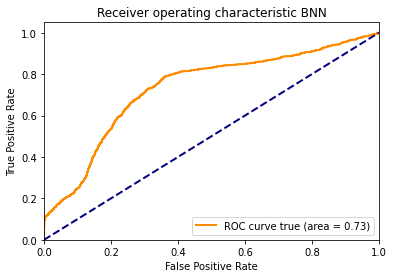

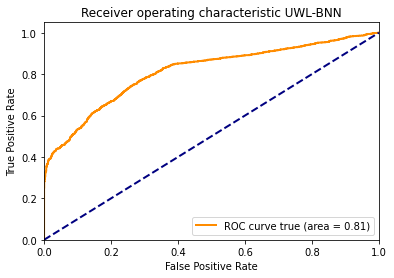

In [ ]:
import random
import numpy as np
import tensorflow as tf
import keras.backend as K
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

def print_roc_bin(y_score, y_test, model_name):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(2):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  plt.figure()
  lw = 2
  plt.plot(fpr[0], tpr[0], color='darkorange',
          lw=lw, label='ROC curve true (area = %0.2f)' % roc_auc[0])
  #plt.plot(fpr[1], tpr[1], color='green',
  #        lw=lw, label='ROC curve fake (area = %0.2f)' % roc_auc[1])
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic '+ model_name)
  plt.legend(loc="lower right")
  plt.show()




x_test = tf.concat([x_test_real, x_test_fake], 0)

y_true_roc = list()
for i in range(y_test_real.shape[0]):
  y_true_roc.append([1., 0.])

for i in range(y_test_fake.shape[0]):
  y_true_roc.append([0., 1.])

y_true_roc = np.array(y_true_roc)

######################## with BNN ###############
y_pred = list()

for t in range(utils.t):
        y_pred.append(second_model.predict(x_test))

y_pred = np.array(y_pred)

y_pred_mean, y_pred_uc = utils.compute_pred_distribution(y_pred)

pred_class = K.argmax(y_pred_mean, axis=-1)
pred_class = tf.reshape(pred_class, [-1, 1])
class_uc = tf.gather_nd(y_pred_uc, pred_class, batch_dims=1)

class_uc = class_uc.numpy()

for i in range(class_uc.shape[0]):   
  if class_uc[i]<0:
    class_uc[i] = 0

min = class_uc.min()
max = class_uc.max()

uc_norm = (class_uc - min) / (max-min)     #inc tra 0 e 1

y_score_roc = list()

for uc in uc_norm:
  y_score_roc.append([(1-uc), uc])

y_score_roc = np.array(y_score_roc)

print_roc_bin(y_score_roc, y_true_roc, 'BNN')


######################## with UWL-BNN ###############

y_pred = list()

for t in range(utils.t):
  y_pred.append(third_model.predict(x_test))

y_pred = np.array(y_pred)

y_pred_mean, y_pred_uc = utils.compute_pred_distribution(y_pred)

pred_class = K.argmax(y_pred_mean, axis=-1)
pred_class = tf.reshape(pred_class, [-1, 1])
class_uc = tf.gather_nd(y_pred_uc, pred_class, batch_dims=1)

class_uc = class_uc.numpy()

for i in range(class_uc.shape[0]):     
  if class_uc[i]<0:
    class_uc[i] = 0

min = class_uc.min()
max = class_uc.max()

uc_norm = (class_uc - min) / (max-min)     #inc tra 0 e 1

y_score_roc = list()

for uc in uc_norm:
  y_score_roc.append([(1-uc), uc])

y_score_roc = np.array(y_score_roc)

print_roc_bin(y_score_roc, y_true_roc, 'UWL-BNN')


